### Config

In [ ]:
from pathlib import Path
import dill
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

nn_dir = Path(".data/splitting/nn")
n_vectors = {"url": 8, "html": 16}
max_search_radius = 5
filtered_dir = Path(".data/splitting/diversity_filtered")
filtered_dir.mkdir(parents=True, exist_ok=True)

cosine_distance = 0.02

### Phishing

Total samples in test set for url: 76800
Samples with near neighbors at cosine distance of 0.02 in test set for url: 1540
Samples with near neighbors at cosine distance of 0.02 in test set for url: 1540
--------------------------------------------------


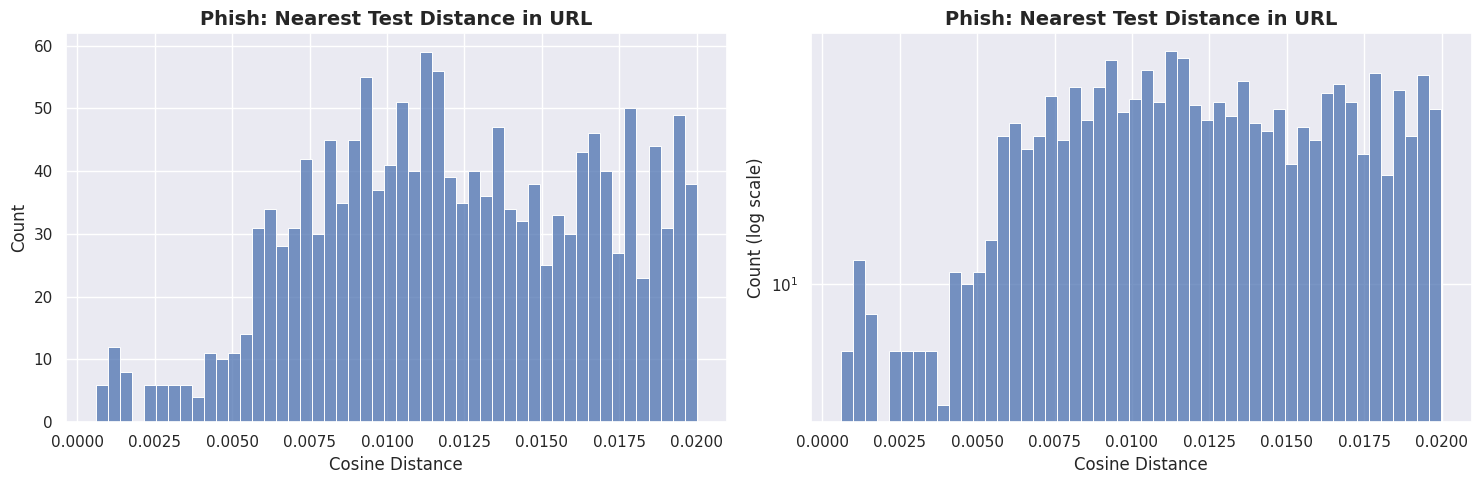

Total samples in test set for html: 76800
Samples with near neighbors at cosine distance of 0.02 in test set for html: 49086
Samples with near neighbors at cosine distance of 0.02 in test set for html: 49086
--------------------------------------------------


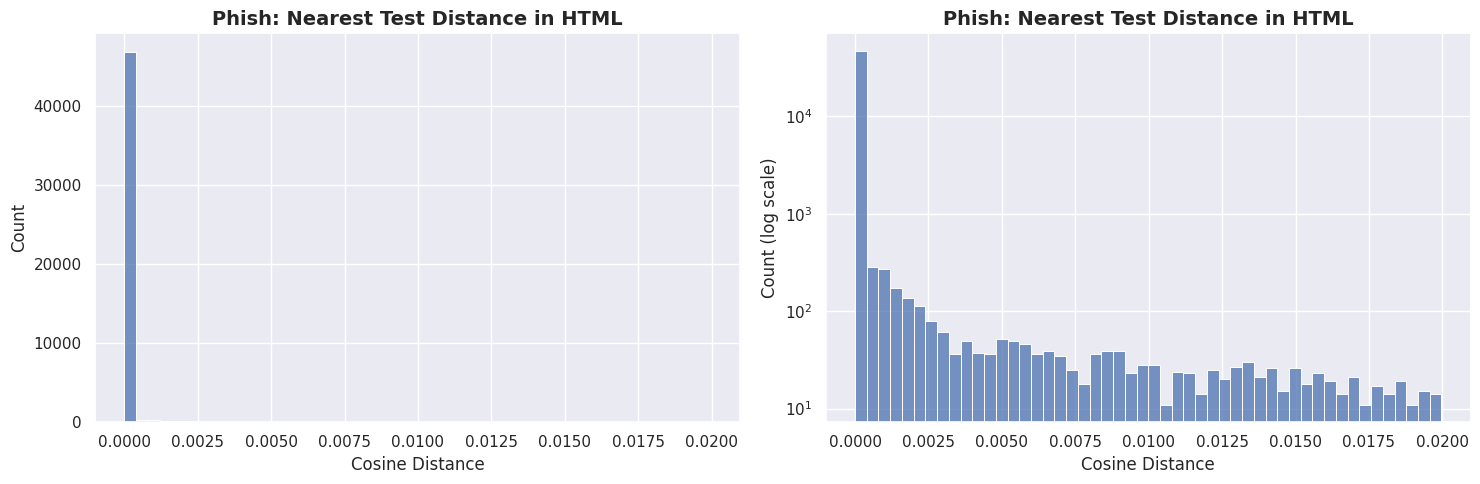

In [2]:
class_type = 'phish'
feat_frames = {}

for feat_type in ['url', 'html']:
    nn_path = nn_dir / f"diversity_test_{feat_type}_{class_type}_{n_vectors[feat_type]}_{max_search_radius}.pkl"
    assert nn_path.exists(), f"NN file not found: {nn_path}"
    with open(nn_path, 'rb') as f:
        min_dist = dill.load(f)
    df = pd.DataFrame(min_dist.items(), columns=['sha256', 'near_ones'])
    print(f"Total samples in test set for {feat_type}: {len(df)}")

    # drop the samples without any near ones
    df['near_ones'] = df['near_ones'].apply(lambda x: None if len(x) == 0 else x)
    df = df.dropna(subset=['near_ones'])
    print(f"Samples with near neighbors at cosine distance of 0.02 in test set for {feat_type}: {len(df)}")

    # filter the samples with any near ones within the cosine distance threshold
    df['near_ones'] = df['near_ones'].apply(lambda x: [a for a in x if a[1] <= cosine_distance])
    df['near_ones'] = df['near_ones'].apply(lambda x: None if len(x) == 0 else x)
    df = df.dropna(subset=['near_ones'])

    print(f"Samples with near neighbors at cosine distance of {cosine_distance} in test set for {feat_type}: {len(df)}")
    print('-'*50)

    # show the nearest distance distribution
    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    min_distance_df = df['near_ones'].apply(lambda x: min([a[1] for a in x]))
    sns.histplot(min_distance_df, bins=50, kde=False, stat='count', ax=axes[0])
    axes[0].set_title(f'{class_type.capitalize()}: Nearest Test Distance in {feat_type.upper()}', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Cosine Distance')
    axes[0].set_ylabel('Count')
    # plot with log scale
    sns.histplot(min_distance_df, bins=50, kde=False, stat='count', ax=axes[1])
    axes[1].set_yscale('log')  
    axes[1].set_title(f'{class_type.capitalize()}: Nearest Test Distance in {feat_type.upper()}', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Cosine Distance')
    axes[1].set_ylabel('Count (log scale)')
    plt.tight_layout()
    plt.show()
    
    feat_frames[feat_type] = df

In [3]:
to_drop = set()

for feat_type, df in feat_frames.items():
    print(f"Processing dropping for feature type: {feat_type}")

    df = feat_frames[feat_type]

    drop_map = {sha256: False for sha256 in df['sha256'].tolist()}

    drop_count = sum(drop_map.values())
    print(f"Drop count before processing {feat_type}: {drop_count}")

    for i, row in tqdm(df.iterrows(), total=len(df), desc="Processing to drop"):
        sha256 = row['sha256']
        near_ones = row['near_ones']
        undropped = [neighbor_sha256 for neighbor_sha256, distance in near_ones if drop_map[neighbor_sha256] == False]
        if len(undropped) > 0:
            drop_map[sha256] = True
            to_drop.add(sha256)
    drop_count = sum(drop_map.values())
    print(f"Drop count after processing {feat_type}: {drop_count}")
    print(f"Retained count within {cosine_distance} cosine distance for {feat_type}: {len(df) - drop_count}")
print('='*50)
print(f"Total to drop across both feature types: {len(to_drop)}")
print(f"Total retained count: {len(min_dist) - len(to_drop)}")

Processing dropping for feature type: url
Drop count before processing url: 0


Processing to drop: 100%|██████████| 1540/1540 [00:00<00:00, 26640.83it/s]


Drop count after processing url: 1073
Retained count within 0.02 cosine distance for url: 467
Processing dropping for feature type: html
Drop count before processing html: 0


Processing to drop: 100%|██████████| 49086/49086 [00:07<00:00, 6968.15it/s] 

Drop count after processing html: 45070
Retained count within 0.02 cosine distance for html: 4016
Total to drop across both feature types: 45160
Total retained count: 31640


#### Save

In [ ]:
filtered_path = filtered_dir / f"{class_type}.pkl"
with open(filtered_path, 'wb') as f:
    dill.dump(to_drop, f)
print(f"Saved filtered drop list of {class_type} to {filtered_path}")

### Benign

Total samples in test set for url: 91260
Samples with near neighbors at cosine distance of 0.02 in test set for url: 32
Samples with near neighbors at cosine distance of 0.02 in test set for url: 32
--------------------------------------------------


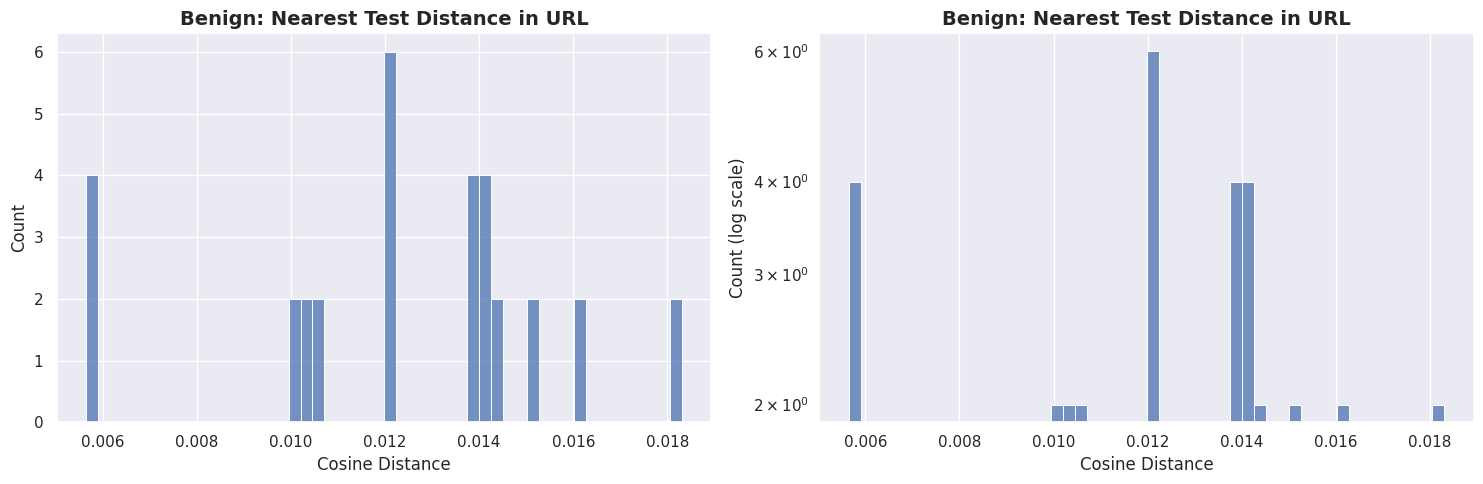

Total samples in test set for html: 91260
Samples with near neighbors at cosine distance of 0.02 in test set for html: 1642
Samples with near neighbors at cosine distance of 0.02 in test set for html: 1642
--------------------------------------------------


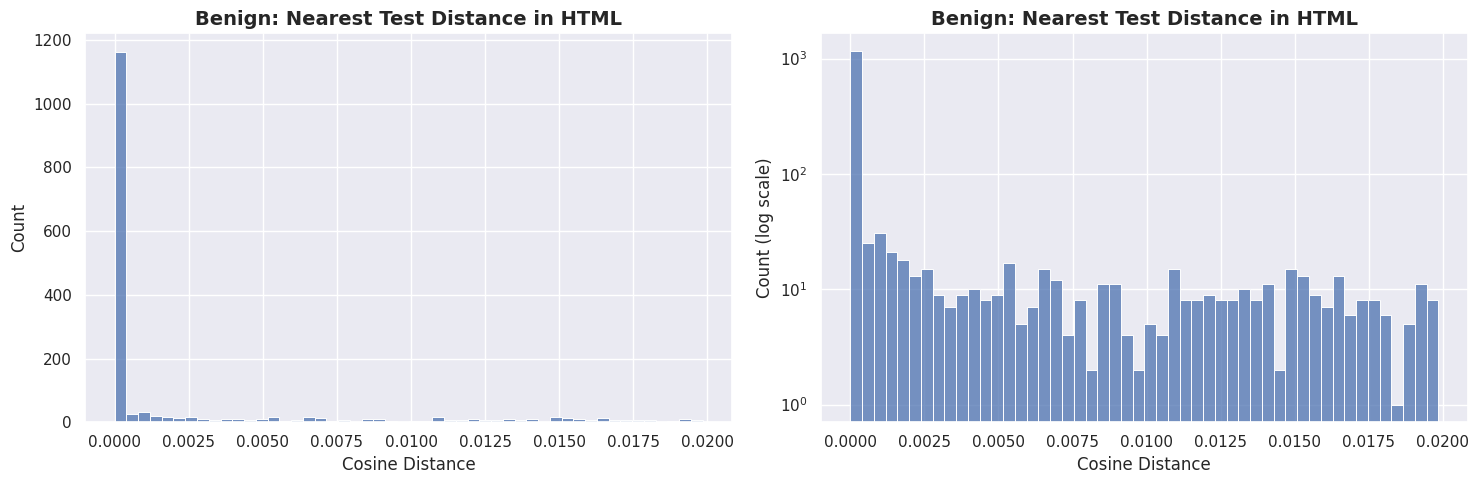

In [5]:
import dill
import pandas as pd

class_type = 'benign'
feat_frames = {}

for feat_type in ['url', 'html']:
    nn_path = nn_dir / f"diversity_test_{feat_type}_{class_type}_{n_vectors[feat_type]}_{max_search_radius}.pkl"
    assert nn_path.exists(), f"NN file not found: {nn_path}"
    with open(nn_path, 'rb') as f:
        min_dist = dill.load(f)
    df = pd.DataFrame(min_dist.items(), columns=['sha256', 'near_ones'])
    print(f"Total samples in test set for {feat_type}: {len(df)}")

    # drop the samples without any near ones
    df['near_ones'] = df['near_ones'].apply(lambda x: None if len(x) == 0 else x)
    df = df.dropna(subset=['near_ones'])
    print(f"Samples with near neighbors at cosine distance of 0.02 in test set for {feat_type}: {len(df)}")

    # filter the samples with any near ones within the cosine distance threshold
    df['near_ones'] = df['near_ones'].apply(lambda x: [a for a in x if a[1] <= cosine_distance])
    df['near_ones'] = df['near_ones'].apply(lambda x: None if len(x) == 0 else x)
    df = df.dropna(subset=['near_ones'])

    print(f"Samples with near neighbors at cosine distance of {cosine_distance} in test set for {feat_type}: {len(df)}")
    print('-'*50)

    # show the nearest distance distribution
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set_theme()

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    min_distance_df = df['near_ones'].apply(lambda x: min([a[1] for a in x]))
    sns.histplot(min_distance_df, bins=50, kde=False, stat='count', ax=axes[0])
    axes[0].set_title(f'{class_type.capitalize()}: Nearest Test Distance in {feat_type.upper()}', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Cosine Distance')
    axes[0].set_ylabel('Count')
    # plot with log scale
    sns.histplot(min_distance_df, bins=50, kde=False, stat='count', ax=axes[1])
    axes[1].set_yscale('log')  
    axes[1].set_title(f'{class_type.capitalize()}: Nearest Test Distance in {feat_type.upper()}', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Cosine Distance')
    axes[1].set_ylabel('Count (log scale)')
    plt.tight_layout()
    plt.show()
    
    feat_frames[feat_type] = df

In [6]:
from tqdm import tqdm

to_drop = set()

for feat_type, df in feat_frames.items():
    print(f"Processing dropping for feature type: {feat_type}")

    df = feat_frames[feat_type]

    drop_map = {sha256: False for sha256 in df['sha256'].tolist()}

    drop_count = sum(drop_map.values())
    print(f"Drop count before processing {feat_type}: {drop_count}")

    for i, row in tqdm(df.iterrows(), total=len(df), desc="Processing to drop"):
        sha256 = row['sha256']
        near_ones = row['near_ones']
        undropped = [neighbor_sha256 for neighbor_sha256, distance in near_ones if drop_map[neighbor_sha256] == False]
        if len(undropped) > 0:
            drop_map[sha256] = True
            to_drop.add(sha256)
    drop_count = sum(drop_map.values())
    print(f"Drop count after processing {feat_type}: {drop_count}")
    print(f"Retained count within {cosine_distance} cosine distance for {feat_type}: {len(df) - drop_count}")
print('='*50)
print(f"Total to drop across both feature types: {len(to_drop)}")
print(f"Total retained count: {len(min_dist) - len(to_drop)}")

Processing dropping for feature type: url
Drop count before processing url: 0


Processing to drop: 100%|██████████| 32/32 [00:01<00:00, 27.56it/s]


Drop count after processing url: 16
Retained count within 0.02 cosine distance for url: 16
Processing dropping for feature type: html
Drop count before processing html: 0


Processing to drop: 100%|██████████| 1642/1642 [00:00<00:00, 32545.48it/s]

Drop count after processing html: 984
Retained count within 0.02 cosine distance for html: 658
Total to drop across both feature types: 990
Total retained count: 90270


#### Save

In [ ]:
filtered_path = filtered_dir / f"{class_type}.pkl"
with open(filtered_path, 'wb') as f:
    dill.dump(to_drop, f)
print(f"Saved filtered drop list of {class_type} to {filtered_path}")